In [ ]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils

In [ ]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'

# Observations

## SOS towers

In [ ]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

In [ ]:
src = sos_df[sos_df.variable.isin([
        'P_10m_c',
        'T_3m_c',
        'RH_10m_c',
        'spd_10m_c',
        'tke_10m_c'
    ])]
src = src.set_index('time').sort_index().loc['20230418']

In [ ]:
alt.Chart(
    src.reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False),
    alt.Row('variable:N'),
).resolve_scale(y='independent').properties(width=400, height = 133)

In [ ]:
sos_df.variable.unique()

In [ ]:
src = sos_df[sos_df.measurement.isin(['u_u_', 'v_v_', 'w_w_'])].query("tower == 'c'")
src = src[src.height.isin([3,10,20])]
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
base = alt.Chart().mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='viridis'),
    alt.StrokeDash('measurement:N')
).properties(width=600)
alt.layer(base, data=src.set_index('time').sort_index().loc['20230415': '20230415'].reset_index()) &\
alt.layer(base, data=src.set_index('time').sort_index().loc['20230418': '20230418'].reset_index())

## Radiosonde

In [ ]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

In [ ]:
# Define the data code and date range
data_code = 'gucsondewnpnM1.b1'
start_date = '2023-04-18'
end_date = '2023-04-18'


In [ ]:
# # Download the data
# files = act.discovery.download_arm_data(
#     username,
#     token,
#     data_code,
#     start_date,
#     end_date,
#     output = os.path.join(data_dir, "gucsondewnpnM1.b1")
# )

In [113]:
sonde_morn = xr.open_dataset(os.path.join(os.path.join(data_dir, "gucsondewnpnM1.b1", "gucsondewnpnM1.b1.20230418.113100.cdf")))
sonde_day = xr.open_dataset(os.path.join(os.path.join(data_dir, "gucsondewnpnM1.b1", "gucsondewnpnM1.b1.20230418.232900.cdf")))

In [114]:
sonde_morn['tpot'] = metpy.calc.potential_temperature(
    sonde_morn['pres'] * units(sonde_morn['pres'].units),
    sonde_morn['tdry'] * units(sonde_morn['tdry'].units),
)
sonde_day['tpot'] = metpy.calc.potential_temperature(
    sonde_day['pres'] * units(sonde_day['pres'].units),
    sonde_day['tdry'] * units(sonde_day['tdry'].units),
)

In [115]:
sonde_day

Magnitude,[308.8573913574219 309.05963134765625 309.3096618652344 ... 550.760498046875 550.8106079101562 550.8440551757812]
Units,kelvin


In [ ]:
src.alt - 

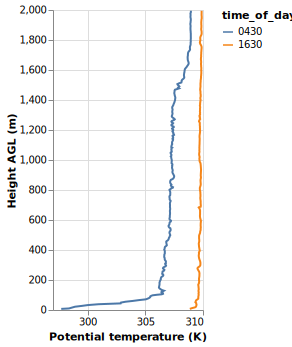

In [126]:
src_morn = sonde_morn.to_dataframe().query("alt < 5000")
src_day = sonde_day.to_dataframe().query("alt < 5000")
src = pd.concat([
        src_morn.assign(time_of_day = '0430'),
        src_day.assign(time_of_day = '1630')
    ])
src['height'] = src.alt - 2891
alt.Chart(
    src.query("height <= 2000")
).mark_line().encode(
    alt.X('tpot:Q').title('Potential temperature (K)'),
    alt.Y('height:Q').title('Height AGL (m)'),
    alt.Color('time_of_day:N'),
    order='height:Q'
).properties(width=150, height = 300)

## TROPoe scans

For April 18, the tropoe data are not available from the arm portal. Bianca gave them to me directly

In [107]:
tropoe_ds = xr.open_dataset(
    "/Users/elischwat/Development/data/sublimationofsnow/tropoe_from_bianca/gucM1tropoeAERI.raso_ctrl.20230418.001005.nc"
)
tropoe_df = tropoe_ds[['theta']].to_dataframe().reset_index()

In [108]:
tropoe_df = utils.modify_df_timezone(tropoe_df, 'UTC', 'US/Mountain')

In [109]:
tropoe_df['height'] = tropoe_df['height']*1000

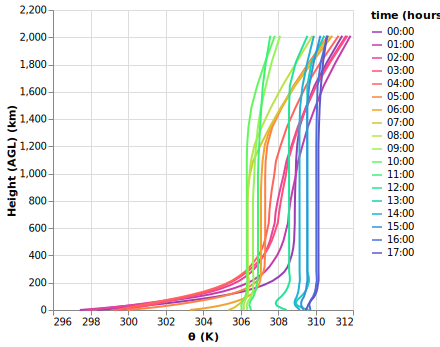

In [110]:
alt.Chart(
    tropoe_df[tropoe_df.time > '20230418'].query("height < 2050")
).mark_line(size=2).encode(
    alt.X('mean(theta):Q').scale(zero=False).title('θ (K)'),
    alt.Y('height').scale(type='linear').title('Height (AGL) (km)'),
    alt.Color('hours(time):O').scale(scheme='rainbow'),
    # alt.Facet('hours(time):O', columns=6),
    order='height',
    tooltip = 'hours(time)'
).properties(width=300, height=300)

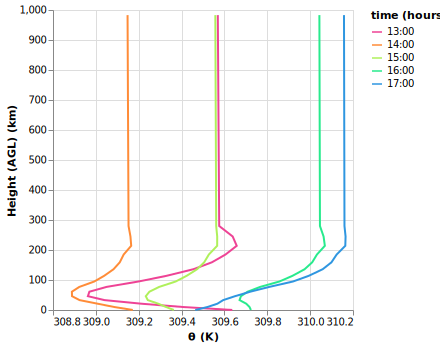

In [111]:
alt.Chart(
    tropoe_df[tropoe_df.time > '20230418 1300'].query("height < 1000")
).mark_line(size=2).encode(
    alt.X('mean(theta):Q').scale(zero=False).title('θ (K)'),
    alt.Y('height').scale(type='linear').title('Height (AGL) (km)'),
    alt.Color('hours(time):O').scale(scheme='rainbow'),
    # alt.Facet('hours(time):O', columns=6),
    order='height',
    tooltip = 'hours(time)'
).properties(width=300, height=300)

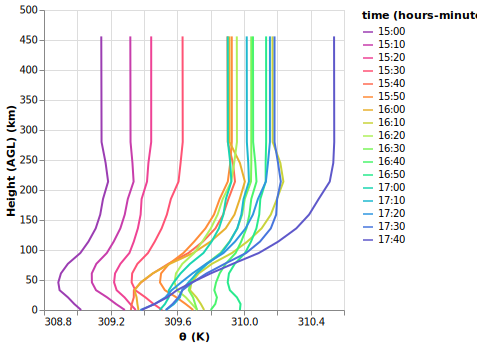

In [112]:
alt.Chart(
    tropoe_df[tropoe_df.time > '20230418 1500'].query("height < 500")
).mark_line(size=2).encode(
    alt.X('theta:Q').scale(zero=False).title('θ (K)'),
    alt.Y('height').scale(type='linear').title('Height (AGL) (km)'),
    alt.Color('hoursminutes(time):O').scale(scheme='rainbow'),
    # alt.Facet('hours(time):O', columns=6),
    order='height',
    tooltip = 'hoursminutes(time)'
).properties(width=300, height=300)

### Combine tropoe and radiosonde plots

In [ ]:
src_morn = sonde_morn.to_dataframe().query("alt < 5000")
src_day = sonde_day.to_dataframe().query("alt < 5000")
both_sondes = pd.concat([
    src_morn.assign(timestamp = '4:30am'),
    src_day.assign(timestamp = '4:30pm')
])
both_sondes
both_sondes.alt = both_sondes.alt - 2889 # this is the approx elevation of the SAIL site

alt.Chart(both_sondes).mark_line().encode(
    alt.X('tpot:Q'),
    alt.Y('alt:Q').scale(zero=False, nice=False),
    alt.Color('timestamp:N'),
    order='alt',
).properties(width=100, height = 200)

In [ ]:

both_tropoe = pd.concat([
    tropoe_df.set_index('time').loc['20230418 04:30'].assign(timestamp = '4:30am'),
    tropoe_df.set_index('time').loc['20230418 16:30'].assign(timestamp = '4:30pm')
])
both_tropoe = both_tropoe.rename(columns={
    'theta':'tpot',
    'height':'alt',
})
both_tropoe = both_tropoe.query(f"alt <= {both_sondes.alt.max()}")

In [ ]:
tropoe_and_sonde_df = pd.concat([
    both_tropoe.query("alt < 5000").assign(type = 'tropoe'),
    both_sondes.assign(type = 'radiosonde')
])

In [ ]:
alt.Chart(tropoe_and_sonde_df.assign(alt = tropoe_and_sonde_df.alt/1000)).mark_line().encode(
    alt.X('tpot:Q').title('θ (K)'),
    alt.Y('alt:Q').scale(zero=False, nice=False).title('Height (AGL) (km)'),
    alt.Color('timestamp:N'),
    alt.StrokeDash('type:N'),
    order='alt',
).properties(width=100, height = 200)

## Doppler Lidar Vertical Velocity Variance

### During April 18

In [ ]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230418"
end_date = "20230419"
# start_date = "20221221"
# end_date = "20221222"
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

In [ ]:
file_list = act.discovery.download_arm_data(
            username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR)

In [97]:
file_list = [f for f in glob.glob(os.path.join(data_dir, DLW_DATA_STREAM, '*.nc')) if '20230418' in f or '20230419' in f]

In [101]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

Text(0.5, 1.0, 'Vertical velocity variance from vertically-staring Doppler Lidar')

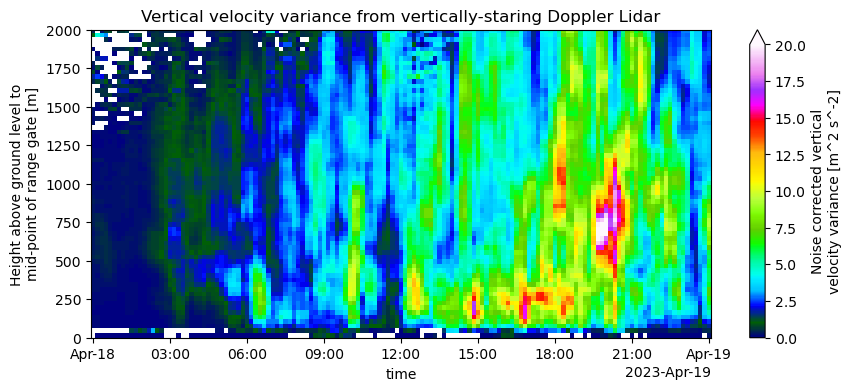

In [106]:
dl_wstats['w_variance'].sel(
    time = slice('20230418 0000', '20230419 0000')
).plot(x = 'time', y='height', figsize=(10,4), vmin=0, vmax=20, cmap='gist_ncar')
plt.ylim(0, 2000)
plt.title('Vertical velocity variance from vertically-staring Doppler Lidar')

In [ ]:
src = dl_wstats.where(dl_wstats['snr'] > 0.008)
alt.Chart(
    src['w_variance'].to_dataframe().reset_index().query("height < 2000").set_index('time').reset_index()
).mark_line().encode(
    alt.X('mean(w_variance):Q'),
    alt.Y('height:Q'),
    alt.Color('hours(time):O').scale(scheme='rainbow'),
    alt.Column('date(time):O'),
    order='height',
).resolve_scale(x='shared', y='shared')

In [ ]:
dl_wstats['w_variance'].plot(x = 'time', y='height', figsize=(10,3), vmin=0, vmax=20, cmap='gist_ncar')
plt.title('Vertical velocity variance from vertically-staring Doppler Lidar')
plt.ylim(0,2000)
plt.xlim('2023-04-18', '20230419 0000')
plt.xticks([
        '20230418 0000', '20230418 0100', '20230418 0200', '20230418 0300', '20230418 0400', '20230418 0500', '20230418 0600', 
        '20230418 0700', '20230418 0800', '20230418 0900', '20230418 1000', '20230418 1100', '20230418 1200',
        '20230418 1300','20230418 1400','20230418 1500','20230418 1600','20230418 1700','20230418 1800',
        '20230418 1900','20230418 2000','20230418 2100','20230418 2200','20230418 2300'
    ], [str(int(f)) for f in np.linspace(0,23, 24)]
)
plt.show()

In [ ]:
# dl_wstats['w_skewness'].plot(x = 'time', y='height', figsize=(10,3), vmin=-5, vmax=5, cmap='RdBu')
utils.modify_xarray_timezone(
    dl_wstats['w_skewness'],
    'UTC',
    'US/Mountain'
).plot(x = 'time', y='height', figsize=(10,3), vmin=-5, vmax=5, cmap='seismic')

ax = plt.gca()

utils.modify_xarray_timezone(
    dl_wstats['w_variance'].sel(height = slice(0,2000)),
    'UTC',
    'US/Mountain'
).plot.contour(x = 'time', y='height', levels=1, colors='k', ax=ax)

ax.set_title('Vertical velocity skewness from vertically-staring Doppler Lidar')
ax.set_ylim(0,2000)
ax.set_xlim('20230418 0000', '20230419 0000')
ax.set_xticks([
        '20230418 0000', '20230418 0100', '20230418 0200', '20230418 0300', '20230418 0400', '20230418 0500', '20230418 0600', 
        '20230418 0700', '20230418 0800', '20230418 0900', '20230418 1000', '20230418 1100', '20230418 1200',
        '20230418 1300','20230418 1400','20230418 1500','20230418 1600','20230418 1700','20230418 1800',
        '20230418 1900','20230418 2000','20230418 2100','20230418 2200','20230418 2300'
    ], [str(int(f)) for f in np.linspace(0,23, 24)]
)

plt.show()

In [ ]:

dl_wstats['w_skewness'].plot(x = 'time', y='height', figsize=(10,3), vmin=-5, vmax=5, cmap='seismic')

ax = plt.gca()

dl_wstats['w_variance'].sel(height = slice(0,2000)).plot.contour(x = 'time', y='height', levels=1, colors='k', ax=ax)

ax.set_title('Vertical velocity skewness from vertically-staring Doppler Lidar')
ax.set_ylim(0,2000)
ax.set_xlim('20230418 1200', '20230419 0000')
ax.set_xticks([
        '20230418 1200',
        '20230418 1300','20230418 1400','20230418 1500','20230418 1600','20230418 1700','20230418 1800',
        '20230418 1900','20230418 2000','20230418 2100','20230418 2200','20230418 2300'
    ], [str(int(f)) for f in np.linspace(12,23, 12)]
)

plt.show()

### During days with predominantly along valley winds 

In [ ]:
winddir_3m_df = sos_df.query(f"variable == 'dir_3m_c'")
winddir_3m_df = winddir_3m_df.assign(wind_is_alongvalley = 
    (
        ((winddir_3m_df.value > 292.5) & (winddir_3m_df.value < 337.5))
        |
        ((winddir_3m_df.value > 112.5) & (winddir_3m_df.value < 157.5))
    )
)
percent_wind_alongvalley = winddir_3m_df.set_index('time').groupby(pd.Grouper(freq='1440Min'))['wind_is_alongvalley'].sum()/48
dates_with_80percent_alongvalley = percent_wind_alongvalley[percent_wind_alongvalley > 0.7].index.to_series().dt.date
dates_with_80percent_alongvalley = pd.to_datetime(dates_with_80percent_alongvalley).dt.strftime(DATE_FORMAT_STR).values
print(len(dates_with_80percent_alongvalley))

In [ ]:
# DOWNLOAD FILES

# # Inputs
# files = []
# for date in pd.to_datetime(dates_with_80percent_alongvalley).dt.strftime(DATE_FORMAT_STR).values:
#     f = act.discovery.download_arm_data(
#         username, token, DLW_DATA_STREAM, date, date, output = DLW_OUTPUT_DIR
#     )
#     files = files + f

# DOWNLOAD FILES
all_dl_files = glob.glob(os.path.join(DLW_OUTPUT_DIR, "*.nc"))

In [ ]:
fs = []
for f in all_dl_files:
    for d in dates_with_80percent_alongvalley:
        if d.replace('-', '') in f:
            fs.append(f)
len(fs)

In [ ]:
dl_wstats_with_80percent_alongvalley = xr.open_mfdataset(fs)

In [ ]:
# dl_wstats = xr.open_mfdataset()
src = utils.modify_xarray_timezone(
    dl_wstats_with_80percent_alongvalley['w_variance'],
    'UTC',
    'US/Mountain'
).to_dataframe().reset_index()

In [ ]:
src = src.query("height < 2000")
src['hour'] = src['time'].dt.hour

In [ ]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [ ]:
src_agg_stats = src.groupby(['hour', 'height'])['w_variance'].agg(['mean', 'median', percentile(.25), percentile(.75)])
src_agg_stats

In [ ]:
alt.Chart(src_agg_stats.reset_index()).mark_rule().encode(
    alt.X('mean(percentile_25):Q'),
    alt.X2('mean(percentile_75):Q'),
    alt.Y('height:Q'),
) + alt.Chart(src_agg_stats.reset_index()).transform_fold([
    'mean', 'median'
]).mark_circle().encode(
    alt.X('mean(value):Q'),
    alt.Y('height:Q'),
    # alt.Shape('key:N').scale(range=['circle', 'stroke']),
    alt.Color('key:N')
).properties(height = 500)

In [ ]:
alt.layer(
        alt.Chart().mark_rule().encode(
        alt.X('mean(percentile_25):Q'),
        alt.X2('mean(percentile_75):Q'),
        alt.Y('height:Q'),
    ), 
    alt.Chart().transform_fold([
        'mean', 'median'
    ]).mark_circle().encode(
        alt.X('mean(value):Q'),
        alt.Y('height:Q'),
        # alt.Shape('key:N').scale(range=['circle', 'stroke']),
        alt.Color('key:N')
    ).properties(height = 500),
    data = src_agg_stats.reset_index()
).facet('hour')

### Extract vertical velocity variance at 900m, around the peak of Gothic Mtn

In [ ]:
w_w_900m = dl_wstats['w_variance'].sel(time = slice('20230418 0600', '20230418 2359'), height = slice(875,925)).mean(dim='height')
w_w_450m = dl_wstats['w_variance'].sel(time = slice('20230418 0600', '20230418 2359'), height = slice(425,475)).mean(dim='height')
w_w_50m = dl_wstats['w_variance'].sel(time = slice('20230418 0600', '20230418 2359'), height = slice(25,75)).mean(dim='height')

(w_w_900m/w_w_900m.max()).plot(figsize=(20,4), color = 'lightblue')
(w_w_450m/w_w_450m.max()).plot(color = 'blue')
(w_w_50m/w_w_50m.max()).plot(color = 'darkblue')

In [ ]:
w_w_multiple_heights_dopplidar_df = w_w_900m.rename('w_w_900m').to_dataframe().join(
    w_w_450m.rename('w_w_450m').to_dataframe()
).join(
    w_w_50m.rename('w_w_50m').to_dataframe()
)
w_w_multiple_heights_dopplidar_chart = alt.Chart(w_w_multiple_heights_dopplidar_df.reset_index()).transform_fold(
    w_w_multiple_heights_dopplidar_df.columns
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color('key:O').scale(domain=['w_w_50m', 'w_w_450m', 'w_w_900m'], scheme='reds')
).properties(height = 200)


## Doppler Lidar Vertical Wind Profiles

In [ ]:
# Inputs
start_date = "20230418"
end_date = "20230420"
DLWProf_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DLWProf_DATA_STREAM_FILEEXT = '.cdf'
DLWProf_OUTPUT_DIR = os.path.join(data_dir, DLWProf_DATA_STREAM)
file_list = act.discovery.download_arm_data(
            username, token, DLWProf_DATA_STREAM, start_date, end_date, output = DLWProf_OUTPUT_DIR)
dl_wprof = xr.open_mfdataset(file_list)

In [ ]:
dl_wprof_df = dl_wprof.to_dataframe().reset_index()
dl_wprof_df['time'] = dl_wprof_df['time'].dt.round('15min')
dl_wprof_df = utils.modify_df_timezone(dl_wprof_df, 'UTC', 'US/Mountain')
dl_wprof_df = dl_wprof_df.set_index('time').loc['20230418': '20230418'].reset_index()

In [ ]:
alt.Chart(
    pd.concat([
            dl_wprof_df.query("height > 250").query("height < 500").groupby("time").mean().reset_index(),
            dl_wprof_df.query("height > 1000").query("height < 1200").groupby("time").mean().reset_index(),
    ])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(wind_speed):Q'),
    alt.Color('height:O').bin(step=250).scale(scheme='viridis')
).properties(width=600)

In [ ]:
alt.Chart(
    dl_wprof_df.query("height < 1500")
).mark_circle(size=15).encode(
    alt.X('wind_direction:Q').axis(values=[0,90,180,270,360]),
    alt.Y('height:Q'),
    alt.Color('minutes(time):O'),
    alt.Facet('hours(time):T', columns=6)
).properties(width = 100, height = 200)

In [ ]:
alt.Chart(
    dl_wprof_df.query("height < 1500")
).mark_circle(size=15).encode(
    alt.X('w:Q').axis(values=[-5,-2.5,0,2.5,5]).scale(domain=[-5,5]),
    alt.Y('height:Q'),
    alt.Color('minutes(time):O'),
    alt.Facet('hours(time):T', columns=6)
).properties(width = 100, height = 200)

### Wind rose

Text(0.5, 1.0, 'April 18, 1km AGL winds')

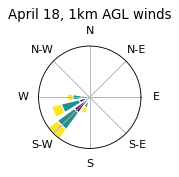

In [127]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax(figsize=(1.6,1.6))
ax.bar(
    dl_wprof_df.query("height < 1000").query("height > 900")['wind_direction'], 
    dl_wprof_df.query("height < 1000").query("height > 900")['wind_speed'], 
    # normed=True, opening=.9, edgecolor='white', bins=1, nsector=17,
    normed=True, opening=0.8, edgecolor="white", bins=[0,10,15]
)

ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
# ax.set_legend(loc='upper right')
ax.set_title('April 18, 1km AGL winds')

## Gothic Sail Tower data

In [ ]:
# Define the data codes for meteorological and turbulence data
data_codes = [
    'gucmetM1.b1',  # Example data code for meteorological data
    'guc30ecorS3.b1'  # Example data code for turbulence data
]

# Define the date range
start_date = '2023-04-15'
end_date = '2023-04-18'

# Loop through each data code and download the data
data_dict = {}
for data_code in data_codes:
    files = act.discovery.download_arm_data(
        username,  # Replace with your ARM username
        token,        # Replace with your ARM token
        data_code,
        start_date,
        end_date,
        output = os.path.join(data_dir, data_code)
    )
    print(files)
    # Load the data into an ACT object and append to the list
    ds = act.io.read_arm_netcdf(files)
    data_dict[data_code] = ds

gothic_met = data_dict[data_codes[0]]
gothic_ec = data_dict[data_codes[1]]

In [ ]:
gothic_ec['TKE'] = (gothic_ec['var_u']**2 + gothic_ec['var_v']**2 + gothic_ec['var_w']**2)**(0.5)

In [ ]:
plt.scatter(
    gothic_ec['wind_spd'].sel(time=slice('20230415', '20230415')), 
    gothic_ec['TKE'].sel(time=slice('20230415', '20230415'))
)
plt.scatter(
    gothic_ec['wind_spd'].sel(time=slice('20230418', '20230418')), 
    gothic_ec['TKE'].sel(time=slice('20230418', '20230418'))
)

In [ ]:
var_u_var_v_chart = alt.Chart(
    gothic_ec[['var_u', 'var_v']].to_dataframe().reset_index()
).transform_fold(['var_u', 'var_v']).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('var_u, var_v (m^2/s^2)'),
    alt.StrokeDash('key:N')
).properties(width = 500, height = 200)

var_w_chart = alt.Chart(
    gothic_ec[['var_w']].to_dataframe().reset_index()
).transform_fold(['var_w']).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('var_w (m^2/s^2)'),
    alt.StrokeDash('key:N')
).properties(width = 500, height = 200)

src = dl_wstats['w_variance'].to_dataframe().reset_index()
src = src.query("height < 2000")

# Create the Altair plot
w_var_chart = alt.Chart(src).mark_square(size=30).encode(
    alt.X('time:T'),
    alt.Y('height:Q'),   
    color=alt.Color('w_variance:Q', scale=alt.Scale(domain=[0, 10]), legend=alt.Legend(title='w_variance'))
).properties(
    width = 500, height = 200,
    title='w_variance over Time and Height'
)

(
    w_var_chart
    &
    (var_u_var_v_chart + var_w_chart).resolve_scale(y='independent')    
).resolve_scale(x='shared', color='independent')

In [ ]:
gothic_ec[['cvar_rot_uw', 'cvar_rot_vw', 'cvar_rot_uv']].to_dataframe().plot()

In [ ]:
gothic_ec['mean_rot_w'].plot()

compare tower data with doppler lidar data

In [ ]:
(
    w_w_multiple_heights_dopplidar_chart 
    &
    (var_u_var_v_chart + var_w_chart).resolve_scale(y='independent')
).resolve_scale(x='shared')

## Cinnamon Ridge Obs.

In [ ]:
cat '/Users/elischwat/Development/data/sublimationofsnow/CIN_11Aug2023/CIN_CR1000_lab_test.dat' | head -10

In [ ]:

file_path = '/Users/elischwat/Development/data/sublimationofsnow/CIN_11Aug2023/CIN_CR1000_Daily.dat'
file_path = '/Users/elischwat/Development/data/sublimationofsnow/CIN_11Aug2023/CIN_CR1000_lab_test.dat'

# Read the .dat file into a DataFrame
df = pd.read_csv(
    file_path, 
    skiprows=[0, 2, 3], 
)  # Adjust the delimiter if necessary

# Display the DataFrame
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')
df = df[['WS_ms_AVG', 'AirTempC_Avg']].astype(float)
df

In [ ]:
df.loc['20230418'].plot()

## XBAND

In [ ]:
ppi_scan_files = sorted(glob.glob(
    "/Users/elischwat/Development/data/sublimationofsnow/gucxprecipradarS2.00/gucxprecipradarS2.00.20230418.220459.raw.nc/*_PPI.nc"
))
for f in ppi_scan_files:
    xband_ppi_eg = xr.open_dataset(os.path.join("/Users/elischwat/Development/data/sublimationofsnow/gucxprecipradarS2.00/gucxprecipradarS2.00.20230418.220459.raw.nc", f))
    xband_ppi_eg = utils.modify_xarray_timezone(xband_ppi_eg, 'UTC', 'US/Mountain')
    xband_ppi_eg = xband_ppi_eg.assign_coords(
        x = xband_ppi_eg['range']*np.cos(np.deg2rad(xband_ppi_eg['azimuth'])),
        y = xband_ppi_eg['range']*np.sin(np.deg2rad(xband_ppi_eg['azimuth']))
    )
    xband_ppi_eg = xband_ppi_eg.where(xband_ppi_eg.range < 10000, drop=True)
    xband_ppi_eg = xband_ppi_eg.where(xband_ppi_eg.azimuth > 270, drop=True)
    xband_ppi_eg = xband_ppi_eg.where(xband_ppi_eg.DBZhv > -1e6)
    plt.pcolormesh(
        xband_ppi_eg.y,
        xband_ppi_eg.x,
        xband_ppi_eg.DBZhv.T,
        cmap='gist_ncar',
        vmin=-20,
        vmax=40
    )
    cbar = plt.colorbar()
    cbar.set_label('equivalent_reflectivity_factor_hv (dBZ)')
    plt.scatter([-3727.111766901333], [6488.493655943312], s=100, color='purple', edgecolor='orange')
    plt.title(
        f"{pd.to_datetime(xband_ppi_eg.time.min().values).strftime('%H:%M:%S')} - {pd.to_datetime(xband_ppi_eg.time.max().values).strftime('%H:%M:%S')}"
    )
    plt.show()

In [ ]:
ppi_scan_files = sorted(glob.glob(
    "/Users/elischwat/Development/data/sublimationofsnow/gucxprecipradarS2.00/gucxprecipradarS2.00.20230418.233226.raw.nc/*_PPI.nc"
))
for f in ppi_scan_files:
    xband_ppi_eg = xr.open_dataset(os.path.join("/Users/elischwat/Development/data/sublimationofsnow/gucxprecipradarS2.00/gucxprecipradarS2.00.20230418.220459.raw.nc", f))
    xband_ppi_eg = utils.modify_xarray_timezone(xband_ppi_eg, 'UTC', 'US/Mountain')
    xband_ppi_eg = xband_ppi_eg.assign_coords(
        x = xband_ppi_eg['range']*np.cos(np.deg2rad(xband_ppi_eg['azimuth'])),
        y = xband_ppi_eg['range']*np.sin(np.deg2rad(xband_ppi_eg['azimuth']))
    )
    xband_ppi_eg = xband_ppi_eg.where(xband_ppi_eg.range < 10000, drop=True)
    xband_ppi_eg = xband_ppi_eg.where(xband_ppi_eg.azimuth > 270, drop=True)
    xband_ppi_eg = xband_ppi_eg.where(xband_ppi_eg.DBZhv > -1e6)
    plt.pcolormesh(
        xband_ppi_eg.y,
        xband_ppi_eg.x,
        xband_ppi_eg.DBZhv.T,
        cmap='gist_ncar',
        vmin=-20,
        vmax=40
    )
    cbar = plt.colorbar()
    cbar.set_label('equivalent_reflectivity_factor_hv (dBZ)')
    plt.scatter([-3727.111766901333], [6488.493655943312], s=100, color='purple', edgecolor='orange')
    plt.title(
        f"{pd.to_datetime(xband_ppi_eg.time.min().values).strftime('%H:%M:%S')} - {pd.to_datetime(xband_ppi_eg.time.max().values).strftime('%H:%M:%S')}"
    )
    plt.show()

# DOWNLOAD ALL RHI SCANS

## Examine mean and variance of RHI scans

In [ ]:
ds_dl_rhi = 'gucdlrhiM1.b1'
# ds_dl_rhi2 = 'gucdlrhi2M1.b1'
startdate = '2023-03-01 0000'
enddate = '2023-03-01 0100'
download_path = os.path.join(data_dir, ds_dl_rhi)
SNR_THRESHOLD = 0.008

In [ ]:
download_path

In [ ]:

import os
from glob import glob
from datetime import datetime, timedelta

INCOMPLETE_DAYS = []

# Define the start and end dates
start_date = datetime.strptime("20230301", "%Y%m%d")
end_date = datetime.strptime("20230620", "%Y%m%d")

# Iterate through all dates
current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    
    # Use glob to find files containing the date string
    pattern = os.path.join(download_path, f"*{date_str.replace('-', '')}*")
    matching_files = glob(pattern)
    
    # Print the number of files for the current date
    print(f"Date: {date_str}, Number of files: {len(matching_files)}")
    
    if len(matching_files) != 192:
        INCOMPLETE_DAYS.append(date_str)
    
    # Move to the next day
    current_date += timedelta(days=1)

In [ ]:
import time

for date_str in INCOMPLETE_DAYS:
    print(f"Downloading for date: {date_str}")
    for hr_str in [
        '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', 
        '12', '13', 
        '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
    ]:
        start = date_str + 'T' + hr_str + ':00:00'
        end = date_str + 'T' + hr_str + ':59:59'
        print(start)
        print(end)

        retry_count = 0
        max_retries = 3  # Set a limit for retries
        while retry_count < max_retries:
            try:
                files = act.discovery.download_arm_data(
                    username, token, ds_dl_rhi, start, end, output=download_path
                )
                pattern = os.path.join(download_path, f"*{date_str.replace('-','')}*")
                matching_files = glob(pattern)
                # Print the number of files for the current date
                print(f"Finished downloading for date: {date_str}, downloaded number of files: {len(matching_files)}")
                break  # Exit the retry loop on success
            except Exception as e:
                retry_count += 1
                print(f"Error occurred: {e}. Retrying {retry_count}/{max_retries}...")
                if retry_count < max_retries:
                    time.sleep(5)  # Wait 5 seconds before retrying
                else:
                    print(f"Failed to download after {max_retries} attempts for date: {date_str}, hour: {hr_str}")

In [ ]:
files = act.discovery.download_arm_data(
    username, token, ds_dl_rhi, '20230304', '20230308', output=download_path
)

In [ ]:
cross_valley_scan_files=glob.glob(os.path.join(download_path, '*.cdf'))

In [ ]:
cross_valley_scan_files = glob.glob(os.path.join(download_path, '*.cdf'))
cross_valley_scan_files = [f for f in cross_valley_scan_files if '20230419' in f or '20230418' in f]
cross_valley_scan_files = [f for f in cross_valley_scan_files if f[-8: -6] in ['15', '18', '45', '48']]
cross_valley_scan_files

all cross-valley scans began on the following minutes:
15, 18, 45, 48

Let's grab just those files.

In [ ]:
datasets = []

# Loop through each file
for file in cross_valley_scan_files[4:]:
    # Open the dataset
    ds = xr.open_dataset(file)
    # Assign the filename as an attribute
    ds.attrs['filename'] = file
    # Append the dataset to the list
    datasets.append(ds)

# Merge all datasets
merged_dataset = xr.merge(datasets)

In [ ]:
one_scan_ds = merged_dataset.sel(time = slice('2023-04-18T00:15:00', '2023-04-18T00:18:00'))

one_scan_ds = one_scan_ds.where(one_scan_ds.range < 2000, drop=True)

one_scan_ds['x'] = one_scan_ds['range']*np.cos(np.deg2rad(one_scan_ds['elevation']))
one_scan_ds['z'] = one_scan_ds['range']*np.sin(np.deg2rad(one_scan_ds['elevation']))

one_scan_ds = one_scan_ds.set_coords(['x', 'z'])


one_scan_ds['attenuated_backscatter'].plot(x='x', y='z')

In [ ]:
rhi_df = merged_dataset.to_dataframe().reset_index()
rhi_df = rhi_df[rhi_df.range < 2000]
# RHI: convert polar coordinates to rectangular coords with the radar at (0,0)
rhi_df['x'] = rhi_df['range']*np.cos(np.deg2rad(rhi_df['elevation']))
rhi_df['z'] = rhi_df['range']*np.sin(np.deg2rad(rhi_df['elevation']))

rhi_df['SNR'] = rhi_df['intensity'] - 1
# rhi_df.loc[rhi_df.eval(f'SNR < {SNR_THRESHOLD}'), 'radial_velocity'] = np.nan

In [ ]:
rhi_df_hourly = rhi_df.set_index('time').groupby([
    pd.Grouper(freq='60min'), 'range', 'elevation'
]).mean()

In [ ]:
def plot_rhi_scan_radial_velocity(df):
    return alt.Chart(df).mark_square(size=30).encode(
        alt.X('x:Q'),
        alt.Y('z:Q'),
        alt.Color('radial_velocity:Q').scale(scheme='redyellowblue', domain=[-10,10])
    ).properties(width = 600, height=300)

In [ ]:
plot_rhi_scan_radial_velocity(rhi_df_hourly.loc['2023-04-18 18:00:00', :, :].reset_index())

In [ ]:
import seaborn as sns
sns.displot(rhi_df_hourly.loc['2023-04-18 18:00:00', :, :].attenuated_backscatter)

In [ ]:

def plot_rhi_scan_attenuated_backscatter(df):
    return alt.Chart(df).mark_square(size=30).encode(
        alt.X('x:Q'),
        alt.Y('z:Q'),
        alt.Color('attenuated_backscatter:Q').scale(scheme='redyellowblue')
        # alt.Color('intensity:Q').scale(scheme='redyellowblue')
    ).properties(width = 600, height=300)
plot_rhi_scan_attenuated_backscatter(
    rhi_df.set_index('time').loc['2023-04-18 18:15:00': '2023-04-18 18:18:00'].query("elevation > 30").query("elevation < 150").reset_index()
)

In [ ]:
ds = xr.open_dataset(cross_valley_scan_files[10])
ds['x'] = ds['range']*np.cos(np.deg2rad(ds['elevation']))
ds['z'] = ds['range']*np.sin(np.deg2rad(ds['elevation']))
df = ds.to_dataframe().reset_index()
src = ds.sel(range=slice(0,4000))
plt.subplots(figsize=(9.6, 4))
plt.contourf(
    src['x'].values.T, src['z'].values.T,
    src['radial_velocity'].values,
    cmap='gist_ncar',
    levels=50
)
plt.colorbar()
plt.gca().set_aspect('equal')
name = f.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
plt.title(name)
plt.show()

In [ ]:
import glob
cross_valley_scan_files = sorted(glob.glob(os.path.join(
    '/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/', '*.cdf')))
cross_valley_scan_files = [f for f in cross_valley_scan_files if 
                           '20230304' in f
                           or '20230305' in f
                           or '20230306' in f
                           or '20230307' in f
                           or '20230308' in f
                           
                        ]
cross_valley_scan_files = [f for f in cross_valley_scan_files if f[-8: -6] in ['15', '18', '45', '48']]
cross_valley_scan_files

In [ ]:
for f in sorted(cross_valley_scan_files):
    try: 
        ds = xr.open_dataset(f)
        ds['x'] = ds['range']*np.cos(np.deg2rad(ds['elevation']))
        ds['z'] = ds['range']*np.sin(np.deg2rad(ds['elevation']))
        ds['x'] = - ds['x']
        df = ds.to_dataframe().reset_index()
        src = ds.sel(range=slice(0,2000))
        plt.subplots(figsize=(9.6, 4))
        plt.contourf(
            src['x'].values.T, src['z'].values.T,
            src['radial_velocity'].values,
            cmap='gist_ncar',
            levels=50
        )
        plt.colorbar()
        plt.gca().set_aspect('equal')
        name = f.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
        plt.title(name)
        plt.savefig('rhi_scans/' + name + '.png')
        plt.close()
    except Exception as exc:
        print(f'Failed on {f}')

In [ ]:
alt.Chart(df).mark_square(size=30).encode(
        alt.X('x:Q'),
        alt.Y('z:Q'),
        alt.Color('attenuated_backscatter:Q').scale(scheme='turbo')
    ).properties(width = 600, height=300)

In [ ]:
alt.Chart(df.query("range < 3000")).mark_rect().encode(
    alt.X('x:Q').bin(step=100),
    alt.Y('z:Q').bin(step=100),
    alt.Color('mean(attenuated_backscatter):Q').scale(scheme='turbo')
).properties(width = 600, height=300)

In [ ]:
alt.Chart(df.query("range < 4000")).mark_square(size=30).encode(
        alt.X('x:Q'),
        alt.Y('z:Q'),
        alt.Color('attenuated_backscatter:Q').scale(scheme='turbo')
    ).properties(width = 600, height=300)

In [ ]:
alt.Chart(df.query("x < 4000").query('x > -4000')).mark_square(size=30).encode(
        alt.X('x:Q'),
        alt.Y('z:Q'),
        alt.Color('intensity:Q').scale(scheme='turbo')
    ).properties(width = 600, height=300)

## Download images of gothic from the xband radar

In [ ]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230418"
end_date = "20230419"
DATA_STREAM = 'guccamweathermainS2'
OUTPUT_DIR = os.path.join(data_dir, DATA_STREAM)
file_list = act.discovery.download_arm_data(
            username, token, DATA_STREAM, end_date, end_date, output = OUTPUT_DIR)

In [ ]:
file_list

# Create Site Map

In [ ]:
import rioxarray as rix
import geopandas as gpd
from shapely import transform

Open files and prep rasters for plotting

In [ ]:
# open rasters
elevation = rix.open_rasterio("/Users/elischwat/Development/snow-hydrology/modules/data/east_river_elevation.tif")
hillshade = rix.open_rasterio("/Users/elischwat/Development/snow-hydrology/modules/data/east_river_hillshade.tif", masked=True)
snowdepth = rix.open_rasterio("/Users/elischwat/Development/snow-hydrology/modules/data/eastriver_snowdepth_2023april01.tif")

# open watershed boundary
upper_east_river_polygon = gpd.read_file('/Users/elischwat/Development/snow-hydrology/modules/data/east_polygon.json').to_crs(snowdepth.rio.crs)
upper_east_river_polygon.geometry = upper_east_river_polygon.geometry.buffer(-2000).apply(lambda g: transform(g, lambda x: x - 2000))


# clip rasters
elevation_clipped = elevation.rio.clip_box(
    *upper_east_river_polygon.geometry.iloc[0].bounds
)
hillshade_clipped = hillshade.rio.clip_box(
    *upper_east_river_polygon.geometry.iloc[0].bounds
)
snowdepth_clipped = snowdepth.rio.clip_box(
    *upper_east_river_polygon.geometry.iloc[0].bounds
)

In [ ]:
from shapely.geometry import box, Point, LineString

Create vector objects for plotting

In [ ]:
zoom_in_box = gpd.GeoDataFrame(geometry=
                               [box(*upper_east_river_polygon.geometry.iloc[0].bounds)]
).set_crs(hillshade.rio.crs)

doppler_lidar_loc = gpd.GeoDataFrame(geometry=[
    Point(dl_wprof.lon.values.item(), dl_wprof.lat.values.item())
]).set_crs('EPSG:4326').to_crs(hillshade.rio.crs)

# create a line representing the cross-valley RHI scan axes (+/- 2000 m)
original_point = doppler_lidar_loc.geometry.iloc[0]
point_minus_2000 = Point(original_point.x - 2000, original_point.y)
point_plus_2000 = Point(original_point.x + 2000, original_point.y)
doppler_lidar_xvalley_scan_axis = gpd.GeoDataFrame(geometry=[
    LineString([point_minus_2000,original_point,point_plus_2000])
]).set_crs(hillshade.rio.crs)

# create datasets of the sonde ascension paths
sonde_morn_df = sonde_morn[['lon', 'lat', 'alt']].to_dataframe().reset_index().query("alt <= 5000")
sonde_morn_df['geometry'] = [Point(xy) for xy in zip(sonde_morn_df['lon'], sonde_morn_df['lat'])]
sonde_day_df = sonde_day[['lon', 'lat', 'alt']].to_dataframe().reset_index().query("alt <= 5000")
sonde_day_df['geometry'] = [Point(xy) for xy in zip(sonde_day_df['lon'], sonde_day_df['lat'])]

sonde_morn_gdf = gpd.GeoDataFrame(sonde_morn_df, geometry='geometry').set_crs('EPSG:4326').to_crs(hillshade.rio.crs)
sonde_day_gdf = gpd.GeoDataFrame(sonde_day_df, geometry='geometry').set_crs('EPSG:4326').to_crs(hillshade.rio.crs)

# Mark loc of xband radar 
xband_point = Point(xband_ppi_eg.longitude.values.item(), xband_ppi_eg.latitude.values.item())
xbandradar_loc_gdf = gpd.GeoDataFrame([{'geometry': xband_point}], crs='EPSG:4326').to_crs(hillshade.rio.crs)

In [ ]:
(xbandradar_loc_gdf.geometry.iloc[0].x - doppler_lidar_loc.geometry.iloc[0].x),\
(xbandradar_loc_gdf.geometry.iloc[0].y - doppler_lidar_loc.geometry.iloc[0].y)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))

hillshade.plot(cmap='Greys_r', add_colorbar=False, ax=axes[0])
elevation.plot(alpha=0.5, cbar_kwargs={'label': "Elevation (m)"}, ax=axes[0], vmin=2400, vmax=4250)
zoom_in_box.plot(ax=axes[0], facecolor='none', edgecolor='red', linewidth=2)
doppler_lidar_loc.plot(ax=axes[0], color='red')
doppler_lidar_xvalley_scan_axis.plot(ax=axes[0], color='red')
sonde_morn_gdf[::30].plot(ax=axes[0], column='alt', cmap='Blues', s=30, edgecolor='black')
sonde_day_gdf[::30].plot(ax=axes[0], column='alt', cmap='Blues', marker='s', s=30, edgecolor='black')
xbandradar_loc_gdf.plot(ax=axes[0], color='orange')

hillshade_clipped.plot(cmap='Greys_r', add_colorbar=False, ax=axes[1])
elevation_clipped.plot(alpha=0.5, cbar_kwargs={'label': "Elevation (m)"}, ax=axes[1], vmin=2400, vmax=4250)
zoom_in_box.plot(ax=axes[1], facecolor='none', edgecolor='red', linewidth=2)
doppler_lidar_loc.plot(ax=axes[1], color='red')
doppler_lidar_xvalley_scan_axis.plot(ax=axes[1], color='red')
sonde_morn_gdf[::30].plot(ax=axes[1], column='alt', cmap='Blues', s=30, edgecolor='black')
sonde_day_gdf[::30].plot(ax=axes[1], column='alt', cmap='Blues', marker='s', s=30, edgecolor='black')
xbandradar_loc_gdf.plot(ax=axes[1], color='orange')

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

axes[1].set_xlim(
    axes[1].get_xlim()[0] - 100,
    axes[1].get_xlim()[1] + 100
)
axes[1].set_ylim(
    axes[1].get_ylim()[0] - 100,
    axes[1].get_ylim()[1] + 100
)

plt.tight_layout()

## Extract elevation profile along radar scan line

In [ ]:
hi_res_dem = rix.open_rasterio("/Users/elischwat/qgis/east_river_valley/UG_dem_3m_v1.tif")

In [ ]:
this_line = doppler_lidar_xvalley_scan_axis.geometry.iloc[0]

In [ ]:
from shapely.ops import unary_union

distance_delta = 10
distances = np.arange(0, this_line.length, distance_delta)
points = [this_line.interpolate(distance) for distance in distances] + [Point(*this_line.coords[-1])]
len(points)

In [ ]:
elev_points = [
    hi_res_dem.interp(
        x = pnt.coords[0][0],
        y = pnt.coords[0][1]
    ) for pnt in points
]

In [ ]:
plt.gcf().get_figheight()

In [ ]:
plt.figure(figsize=(4.8, 0.9))
plt.plot(
    np.concatenate([distances, [4000]]) - 2000,
    (np.array(elev_points) - 2889)/1000
)
plt.xlim(-2000, 2000)
plt.ylabel('Height\n(AGL) (km)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Calculate Brunt-Vaisala Frequency and the Boundary-Layer Separation Regime

Baines (1995) defines three different boundary-layer-separation regimes based on laboratory experiments: (i) boundary-layer separation at the mountain crest (i.e., bluff-body flow separation), (ii) flow separation farther down the lee sidewall below the first wave crest, which he calls post-wave separation, and (iii) complete attachment, that is, no separation occurs. The three flow types are characterized by their location in a regime diagram as a function of H /W and N H /U , where H is the mountain height, W is the length of the lee slope, N is the Brunt–Väisälä frequency, and U is the upstream wind speed. The formation of bluff-body flow separation depends on the ratio between the wavelength of the internal waves 2πU /N and W so that boundary-layer separation occurs if N W /U < π. Post-wave separation, on the other hand, occurs when N H /U is above a critical threshold value.

 We can find these variables at 1630, when the radiosonde has vertical profile allowing estimate of $N$. 
Let's calculate these variables at 900m, the approximate height of Gothic.

Calculate N from the afternoon radiosonde

In [ ]:
sonde_day['N'] = metpy.calc.brunt_vaisala_frequency(
    sonde_day['alt'] * units(sonde_day['alt'].units),
    metpy.calc.potential_temperature(
        sonde_day['pres'] * units(sonde_day['pres'].units),
        sonde_day['tdry'] * units(sonde_day['tdry'].units),
    )
)
n_df = sonde_day[['N', 'alt']].to_dataframe()
n_df['alt'] = n_df['alt'] - n_df['alt'].min()

N = n_df[n_df.alt > 875][n_df.alt < 925].mean()['N']

Calculate U from the cinnamon ridge data

In [ ]:
U = df.loc['20230418 1630']['WS_ms_AVG']

In [ ]:
H = 500 # meters, mountain height, height of Gothic relative to the top of the ridge immediately SW of Gothic
W = 1600 # meters, distance btwn gothic ridge peak and center valley of Gothic, along a SW-NE transect line

In [ ]:
leeside_properties_df = df.loc['20230418'][['WS_ms_AVG']].copy()
leeside_properties_df = leeside_properties_df.rename(columns={'WS_ms_AVG': 'U'})
leeside_properties_df['H'] = H
leeside_properties_df['W'] = W
leeside_properties_df['N'] = N
leeside_properties_df['x'] = leeside_properties_df.N * leeside_properties_df.H / leeside_properties_df.U
leeside_properties_df['y'] = leeside_properties_df.H / leeside_properties_df.W
leeside_properties_df = leeside_properties_df.reset_index()

In [ ]:
leeside_properties_df.head()

In [ ]:
alt.Chart(
    leeside_properties_df[leeside_properties_df.TIMESTAMP.dt.hour%2 == 0]
).mark_circle().encode(
    alt.X('mean(x):Q').scale(domain = [0.1, 1], type='log').title('N H / U'), 
    alt.Y('mean(y):Q').scale(domain = [0.01, 10], type='log').title('H / W'),
    alt.Color('hours(TIMESTAMP):O').scale(scheme='rainbow') 
).properties(width=150, height=150)

In [ ]:
plt.scatter(leeside_properties_df['x'], leeside_properties_df['y'])
plt.xlim(0.1, 10)
plt.ylim(0.01,10)
plt.xscale('log')
plt.yscale('log')

from matplotlib.ticker import ScalarFormatter
# Use ScalarFormatter to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

plt.show()

# Seasonal analysis

## Compare: ridge-line w'w' with surface w'w'

Combine DL measurements of w'w' at 900m (from daily datasets) into one dataset

In [ ]:
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

In [ ]:
file_list = glob.glob(os.path.join(DLW_OUTPUT_DIR, '*.nc'))

In [ ]:
daily_900m_wvar_datasets = []
for f in tqdm(file_list):
    dl_wstats = xr.open_dataset(f)
    w_w_900m = dl_wstats['w_variance'].sel(
            height = slice(875,925)
        ).mean(dim='height')
    daily_900m_wvar_datasets.append(w_w_900m)

In [ ]:
dl_900m_wvar = xr.merge(daily_900m_wvar_datasets)

Combine tower EC measurements of w'w' (from daily datasets) into one dataset

In [ ]:
# DOWNLOAD MISSING DATA
# # Define the data codes for meteorological and turbulence data
# data_codes = [
#     'gucmetM1.b1',  # Example data code for meteorological data
#       # Example data code for turbulence data
# ]

# # Define the date range
# start_date = '2023-04-18'
# end_date = '2023-04-18'

# # Loop through each data code and download the data
# data_dict = {}
# for data_code in data_codes:
#     files = act.discovery.download_arm_data(
#         username,  # Replace with your ARM username
#         token,        # Replace with your ARM token
#         data_code,
#         start_date,
#         end_date,
#         output = os.path.join(data_dir, 'guc30ecorS3.b1')
#     )
#     print(files)
#     # Load the data into an ACT object and append to the list
#     ds = act.io.read_arm_netcdf(files)
#     data_dict[data_code] = ds

# gothic_met = data_dict[data_codes[0]]
# gothic_ec = data_dict[data_codes[1]]

In [ ]:

daily_gothic_ecor_datasets = []
for f in tqdm(
    sorted(glob.glob(os.path.join(data_dir, 'guc30ecorS3.b1', '*')))
):
    daily_gothic_ecor_datasets.append(
        xr.open_dataset(f)['var_w']
    )

In [ ]:
gothic_ecor_wvar = xr.merge(daily_gothic_ecor_datasets)

Compare

In [ ]:
wvar_meas = dl_900m_wvar.to_dataframe().join(
    gothic_ecor_wvar.to_dataframe()
).dropna().rename(columns = {
    'w_variance': "900m w_w_",
    'var_w': "3m w_w_",
})

Use synoptic wind measurements to classify timestamps as cross or along-valley winds


In [ ]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files)
prof_df = prof_ds.to_dataframe()

In [ ]:
hourly_mean_prof_df = prof_df.query("height > 950").query("height < 1100")[['wind_speed', 'wind_direction']].reset_index().set_index('time').groupby(pd.Grouper(freq='30min')).mean()

In [ ]:
along_valley_wind_times = hourly_mean_prof_df[
    (hourly_mean_prof_df.wind_direction > 299)
    & (hourly_mean_prof_df.wind_direction < 345 )
].index.values
cross_valley_wind_times = hourly_mean_prof_df[
    (hourly_mean_prof_df.wind_direction > 202)
    & (hourly_mean_prof_df.wind_direction < 248 )
].index.values

In [ ]:
pd.DataFrame(along_valley_wind_times).to_parquet("along_valley_wind_times.parquet")
pd.DataFrame(cross_valley_wind_times).to_parquet("cross_valley_wind_times.parquet")

Assign cross/along-valley label to the w'w' measurements

In [ ]:
wvar_meas['along_valley'] = wvar_meas.index.isin(along_valley_wind_times)
wvar_meas['cross_valley'] = wvar_meas.index.isin(cross_valley_wind_times)
wvar_meas = wvar_meas[wvar_meas.along_valley | wvar_meas.cross_valley]
wvar_meas['synoptic wind dir'] = np.where(wvar_meas['along_valley'], 'along valley', 'cross valley')

In [ ]:
alt.Chart(wvar_meas).mark_bar().encode(
    alt.X('900m w_w_:Q', bin=True, title='900m w_w_'),
    alt.Y('count()', title='Frequency')
).properties(
    title='Histogram of 900m w_w_',
) | alt.Chart(wvar_meas).mark_bar().encode(
    alt.X('3m w_w_:Q', bin=True, title='900m w_w_'),
    alt.Y('count()', title='Frequency')
).properties(
    title='Histogram of 3m w_w_',
)

In [ ]:
# Create new normalized columns
wvar_meas['900m w_w_ normalized'] = wvar_meas['900m w_w_'] / wvar_meas['900m w_w_'].mean()
wvar_meas['3m w_w_ normalized'] = wvar_meas['3m w_w_'] / wvar_meas['3m w_w_'].mean()

In [ ]:
import statsmodels.api as sm

# Function to fit a line and calculate the uncertainty in the slope and R-squared
def fit_line_with_uncertainty(df):
    X = df[['900m w_w_ normalized']].values  # Independent variable
    y = df['3m w_w_ normalized'].values  # Dependent variable
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    return model, model.rsquared

along_valley_df = wvar_meas[wvar_meas.along_valley]
cross_valley_df = wvar_meas[wvar_meas.cross_valley]

# Fit lines for both datasets
model_along_valley, r2_along_valley = fit_line_with_uncertainty(along_valley_df)
model_cross_valley, r2_cross_valley = fit_line_with_uncertainty(cross_valley_df)

# Print the coefficients, intercepts, uncertainties, and R-squared values
print("Along Valley: Coefficient =", model_along_valley.params[1], 
      "Intercept =", model_along_valley.params[0], 
      "Uncertainty in Slope =", model_along_valley.bse[1],
      "R-squared =", r2_along_valley)

print("Cross Valley: Coefficient =", model_cross_valley.params[1], 
      "Intercept =", model_cross_valley.params[0], 
      "Uncertainty in Slope =", model_cross_valley.bse[1],
      "R-squared =", r2_cross_valley)

In [ ]:
alt.Chart(wvar_meas).mark_circle(size=10).encode(
    alt.X("900m w_w_:Q"),
    alt.Y("3m w_w_:Q"),
    alt.Color('synoptic wind dir:N')
) | alt.Chart(wvar_meas).mark_circle(size=10).encode(
    alt.X("900m w_w_ normalized:Q").scale(domain = [0,10]),
    alt.Y("3m w_w_ normalized:Q").scale(domain = [0,10]),
    alt.Color('synoptic wind dir:N')
)

In [ ]:
import altair as alt
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming wvar_meas is your DataFrame and the normalized columns are already created
# Split the dataset based on 'synoptic wind dir'
along_valley_df = wvar_meas[wvar_meas['synoptic wind dir'] == 'along valley']
cross_valley_df = wvar_meas[wvar_meas['synoptic wind dir'] == 'cross valley']

# Function to fit a line and calculate the uncertainty in the slope and R-squared
def fit_line_with_uncertainty(df):
    X = df[['900m w_w_ normalized']].values  # Independent variable
    y = df['3m w_w_ normalized'].values  # Dependent variable
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    return model, model.rsquared

# Fit lines for both datasets
model_along_valley, r2_along_valley = fit_line_with_uncertainty(along_valley_df)
model_cross_valley, r2_cross_valley = fit_line_with_uncertainty(cross_valley_df)

# Extract coefficients and intercepts
slope_along_valley = model_along_valley.params[1]
intercept_along_valley = model_along_valley.params[0]
slope_cross_valley = model_cross_valley.params[1]
intercept_cross_valley = model_cross_valley.params[0]

base_chart_normalized = alt.Chart(wvar_meas).mark_circle(size=10).encode(
    alt.X("900m w_w_ normalized:Q", scale=alt.Scale(domain=[0, 10], clamp=True)),
    alt.Y("3m w_w_ normalized:Q", scale=alt.Scale(domain=[0, 10], clamp=True)),
    alt.Color('synoptic wind dir:N')
)


# Create the fitted lines
line_along_valley = alt.Chart(along_valley_df).mark_line(color='#1f77b4').encode(
    alt.X('900m w_w_ normalized:Q'),
    alt.Y('3m w_w_ normalized:Q')
).transform_regression(
    '900m w_w_ normalized', '3m w_w_ normalized'
)

line_cross_valley = alt.Chart(cross_valley_df).mark_line(color='#ff7f0e').encode(
    alt.X('900m w_w_ normalized:Q'),
    alt.Y('3m w_w_ normalized:Q')
).transform_regression(
    '900m w_w_ normalized', '3m w_w_ normalized'
)

(base_chart_normalized + line_along_valley + line_cross_valley).properties(
    title = f'Along valley r² = {round(r2_along_valley, 2)}, Cross valley r² = {round(r2_cross_valley, 2)}, '
)

## Examine seasonal behavior of vertical velocity statistics

In [ ]:
file_list_2022_23_season = sorted(file_list)[425: 621]
file_list_2022_23_season[0], file_list_2022_23_season[-1]

In [ ]:
daily_wvar_datasets = []
for f in tqdm(file_list_2022_23_season):
    # dl_wstats = xr.open_dataset(f)[['w_variance']].coarsen(height=2, boundary='trim').mean()
    dl_wstats = xr.open_dataset(f)[['w_variance']]
    daily_wvar_datasets.append(dl_wstats)

In [ ]:
dl_wvar = xr.merge(daily_wvar_datasets)

In [ ]:
src = dl_wvar.to_dataframe()
src = src.reset_index().set_index('time')
src['hour_of_day'] = src.index.hour
src = src.groupby(['hour_of_day', 'height']).mean().query("height <= 2000")
alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('w_variance:Q'),
    alt.Y('height:Q'),
    # alt.Color('hour_of_day:O'),
    alt.Facet('hour_of_day:O', columns=6),
    order = 'height'
).properties(width=100)

## KPS Skewness

In [ ]:
sos_ds = xr.open_dataset("../paper1/process_slow_data/sos_ds_temp_storage_30min_straightup.cdf")

In [ ]:
sos_df_5min = sos_ds[['w_w_w__3m_c', 'w_w_w__5m_c', 'w_w_w__10m_c', 'w_w_w__15m_c', 'w_w_w__20m_c']].to_dataframe()

In [ ]:
sos_df_5min = sos_df_5min.melt(ignore_index=False)

In [ ]:
sos_df_5min.head()

In [ ]:

alt.Chart(
    utils.modify_df_timezone(sos_df_5min.reset_index(), 'UTC', 'US/Mountain')
).transform_filter(
    'month(datum.time) != 10' 
).mark_line().encode(
    alt.X('hoursminutes(time)'),
    alt.Y('mean(value)'),
    alt.Color('variable'),
    alt.Facet('month(time)', columns=3)
).properties(width=400)